In [1]:
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

import os
import warnings
warnings.filterwarnings('ignore')

from cloudbandpy.load_driver import run_load_data

from cloudbandpy.cb_detection import detection_workflow
from cloudbandpy.io_utilities import create_list_of_dates, load_ymlfile, add_startend_datetime2config, write_cloud_bands_to_netcdf
from cloudbandpy.time_utilities import create_array_of_times, convert_num2date

Load configuration file and make adjustements for this test case

In [2]:
base_dir = "../../"

config_file = os.path.join(base_dir, "config/config_cbworkflow_southPacific.yml")
config = load_ymlfile(config_file, isconfigfile=True)
config_event = config.copy()
# Make sure that the period for the cloud bands cover the same period as the example data
config_event["startdate"] = "20210223.00"
config_event["enddate"] = "20210227.00"

dirdata = "data/"
config_event["clouddata_path"] = os.path.join(base_dir, "data")
config_event["parameters_file"] = os.path.join(
    base_dir, "parameters/parameters_southhemisphere.yml"
)
# No need to save any files
config_event["load_saved_files"] = False
config_event["save_dailyvar"] = False
config_event["save_listcloudbands"] = False

# filepath = f"{config['saved_dirpath']}list_of_cloud_bands"+config['startdate']+"-"+config['enddate']+"-"+config['domain']+".bin"
# print("Example data exists:", os.path.isfile(filepath))
# print("file is:", filepath)
print(config)

2024-05-07 10:46:34,525 - io_utilities.load_ymlfile - INFO: Configuration file loaded


{'run_inheritance_tracking': True, 'startdate': '20160101.00', 'enddate': '20160130.00', 'domain': 'southPacific', 'hemisphere': 'south', 'lon_west': 130, 'lon_east': 290, 'lat_north': 5, 'lat_south': -50, 'clouddata_path': './ERA5/netcdf/3hourly/surface_level/', 'varname_infilename': 'top_net_thermal_radiation', 'qd_var': True, 'datatimeresolution': 3.0, 'period_detection': 24.0, 'olr_convert2wm2': True, 'varname': 'ttr', 'timecoord_name': 'time', 'xcoord_name': 'longitude', 'ycoord_name': 'latitude', 'select_djfm': False, 'parameters_file': './cloudbandPy/parameters/parameters_southhemisphere.yml', 'saved_dirpath': './cloud_band_files', 'save_dailyvar': False, 'save_listcloudbands': True, 'load_saved_files': False, 'dir_figures': './cloud_band_figures', 'fig_detection_process': False, 'fig_time_evolution_object': False, 'fig_time_evolution_var_cloudband': False, 'fig_overlay_cloudband': False, 'fig_show_bbox_around_blobs': False, 'fig_inheritance_tracking': False, 'fig_density': Fals

Get OLR on 3-hourly data (one hour mean from ERA5)

In [3]:
config_event["qd_var"] = True
olr2process, parameters, lats, lons, _ = run_load_data(config_event)

2024-05-07 10:46:34,533 - load_driver.run_load_data - INFO: Loading data and parameters 
2024-05-07 10:46:34,537 - io_utilities.load_ymlfile - INFO: Parameters file loaded
2024-05-07 10:46:34,538 - io_utilities.load_dataset - INFO: Loading dataset from ../../data
2024-05-07 10:46:34,538 - io_utilities.load_dataset - INFO: Loading 2016 --> 2016
2024-05-07 10:46:36,601 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done
2024-05-07 10:46:36,603 - io_utilities.make_daily_average - INFO: Computation of daily average
2024-05-07 10:46:37,405 - io_utilities.make_daily_average - INFO: Computation of daily average done
2024-05-07 10:46:37,408 - io_utilities.load_dataset - INFO: Dataset loaded


Load cloud bands from the South Pacific for the dates specified in the analyses config file

In [4]:
add_startend_datetime2config(config_event)
listofdates = create_list_of_dates(config_event)
print(str(len(listofdates))+" dates created from "+str(listofdates[0])+" to "+str(listofdates[-1]))

5 dates created from 2021-02-23 00:00:00 to 2021-02-27 00:00:00


Load data

In [5]:
olr2process, parameters, lats, lons, resolution = run_load_data(config_event)

2024-05-07 10:46:37,462 - load_driver.run_load_data - INFO: Loading data and parameters 
2024-05-07 10:46:37,466 - io_utilities.load_ymlfile - INFO: Parameters file loaded
2024-05-07 10:46:37,467 - io_utilities.load_dataset - INFO: Loading dataset from ../../data
2024-05-07 10:46:37,467 - io_utilities.load_dataset - INFO: Loading 2021 --> 2021
2024-05-07 10:46:38,849 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done
2024-05-07 10:46:38,851 - io_utilities.make_daily_average - INFO: Computation of daily average
2024-05-07 10:46:38,986 - io_utilities.make_daily_average - INFO: Computation of daily average done
2024-05-07 10:46:38,988 - io_utilities.load_dataset - INFO: Dataset loaded


Run detection

In [6]:
(
    fill_binarize_data,
    dilation,
    labelled_blobs,
    labelled_candidates,
    cloud_bands_map,
    list_of_candidates,
    list_of_cloud_bands,
) = detection_workflow(
    var2process=olr2process,
    parameters=parameters,
    latitudes=lats,
    longitudes=lons,
    resolution=resolution,
    listofdates=listofdates,
    config=config,
)

2024-05-07 10:46:39,022 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2024-05-07 10:46:39,345 - cb_detection.detection_workflow - INFO: Cloud band detection done


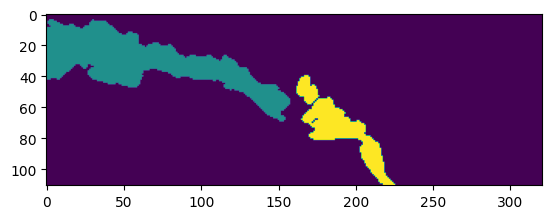

In [7]:
plt.imshow(cloud_bands_map[1])

Save to netCDF file

In [8]:
try: os.remove(f"cloud_bands_{config_event['startdate'][:4]}.nc")
except FileNotFoundError: print(f"File not found.")
write_cloud_bands_to_netcdf(list_of_cloud_bands=list_of_cloud_bands, lons=lons, lats=lats, config=config_event)

In [11]:
ds=nc.Dataset(f"cloud_bands_{config_event['startdate'][:4]}.nc", "r")
times=ds.variables["time"][...]
print(times)
print(nc.num2date(times, "hours since 1900-01-01 00:00:00.0", calendar="gregorian"))


[44248. 44249. 44250. 44251. 44252.]
[cftime.DatetimeGregorian(2021, 2, 23, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2021, 2, 24, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2021, 2, 25, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2021, 2, 26, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2021, 2, 27, 0, 0, 0, 0, has_year_zero=False)]
